!pip install statsmodels
!pip install plotly
!pip install plotly-express
!pip install mlflow

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statistics import mean, median

from time import time

def convert(seconds): 
    min, sec = divmod(seconds, 60) 
    hour, min = divmod(min, 60) 
    return "%d:%02d:%02d" % (hour, min, sec) 

%matplotlib inline 


### Cargamos los datos NSL-KDD

In [2]:
columnas = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent'
,'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count'
,'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate'
,'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level']


testskdd = pd.read_csv('datav2/NSL-KDD/KDDTest+.txt',names = columnas)
testskdd21 = pd.read_csv('datav2/NSL-KDD/KDDTest-21.txt',names = columnas)
traindd = pd.read_csv('datav2/NSL-KDD/KDDTrain+.txt',names = columnas)
traindd20 = pd.read_csv('datav2/NSL-KDD/KDDTrain+_20Percent.txt',names = columnas)

data = pd.concat([testskdd, testskdd21,traindd,traindd20])

### Vamos a quitar registros duplicados a nivel de filas, con el fin de mejorar la lectura de los datos

In [3]:
filasAntesDeQuitarDuplicados = data.shape[0]
data = data.drop_duplicates(subset=columnas)
filasDespuesDeQuitarDuplicados = data.shape[0]
print("Cantidad de filas antes de quitar duplicados {0} y después de quitar duplicados {1}".format(filasAntesDeQuitarDuplicados,filasDespuesDeQuitarDuplicados))

Cantidad de filas antes de quitar duplicados 185559 y después de quitar duplicados 147907


### Antes de continuar, vamos a agrupar los tipos de ataques, en 4 categorías y el resto seria no ataque, lo cual vamos a etiquetar como normal
##### Esto unicamente con el fin de poder explorar los datos

In [4]:
convertirAttack = data['attack']

ReduciendoLarepresentancionDeTipoAtaques = []

tiposDoS = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
tiposProbe = ("ipsweep","mscan","nmap","portsweep","saint","satan")
tiposU2R = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
tiposR2L = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")

for item in convertirAttack:
    if item in tiposDoS:
        ReduciendoLarepresentancionDeTipoAtaques.append("DoS")
    elif item in tiposProbe:
        ReduciendoLarepresentancionDeTipoAtaques.append("Probe")
    elif item in tiposU2R:
        ReduciendoLarepresentancionDeTipoAtaques.append("U2R")
    elif item in tiposR2L:
        ReduciendoLarepresentancionDeTipoAtaques.append("R2L")
    else:
        ReduciendoLarepresentancionDeTipoAtaques.append("Normal") 

In [5]:
print("Dos {0} - Probe - {1} - U2R {2} - R2L {3}".format(len(tiposDoS),len(tiposProbe),len(tiposU2R),len(tiposR2L)))

Dos 11 - Probe - 6 - U2R 7 - R2L 15


#### Vamos a explorar la columna duración para los tipos definidos como ataques, con el fin de darnos una idea de su distribución

In [6]:
duracionDeTiposAtaque = data[data['attack'] != 'normal']['duration']

somelist_df = pd.DataFrame(duracionDeTiposAtaque)

print("Cantidad de registros {0} - Cantidad de no ataques {1} - Cantidad de ataques {2}".format(filasDespuesDeQuitarDuplicados, (filasDespuesDeQuitarDuplicados - somelist_df.shape[0]),somelist_df.shape[0] ))

Cantidad de registros 147907 - Cantidad de no ataques 76967 - Cantidad de ataques 70940


In [7]:
somelist_df.describe()

,duration
count,70940.000000
mean,412.971102
std,3290.761042
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,57715.000000


##### Vamos a explorar la cantidad de columnas que tenemos por tipo de datos

In [8]:
print("Cantidad de columnas: {0}".format(data.shape[1]))
pd.value_counts(data.dtypes)

Cantidad de columnas: 43


int64      24
float64    15
object      4
dtype: int64

### Exploramos nuestras columnas alfanumérico

In [9]:
columnasTipoObject = [ i for i in data.columns.values if (data.dtypes[i] == "object")  ]

print("Columnas de tipo alfanumérico: {0} - Total: {1}".format(columnasTipoObject, len(columnasTipoObject)))

Columnas de tipo alfanumérico: ['protocol_type', 'service', 'flag', 'attack'] - Total: 4


#### Validamos la distribución de los datos no numéricos

In [10]:
data.describe(exclude="number")

,protocol_type,service,flag,attack
count,147907,147907,147907,147907
unique,3,70,11,40
top,tcp,http,SF,normal
freq,121361,48168,89394,76967


In [11]:
data[columnasTipoObject].head(6)

,protocol_type,service,flag,attack
0,tcp,private,REJ,neptune
1,tcp,private,REJ,neptune
2,tcp,ftp_data,SF,normal
3,icmp,eco_i,SF,saint
4,tcp,telnet,RSTO,mscan
5,tcp,http,SF,normal


### Explorar si tenemos datos null en alguna columna

In [12]:
pd.isnull(data).sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

# Explorando dataset Completo

In [13]:
data.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


### Validamos la distribución de los datos de cada columna

In [14]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,147907.000000,1.479070e+05,1.479070e+05,147907.000000,147907.000000,147907.000000,147907.000000,147907.000000,147907.000000,147907.000000,...,147907.000000,147907.000000,147907.000000,147907.000000,147907.000000,147907.000000,147907.000000,147907.000000,147907.000000,147907.000000
mean,277.920802,4.038680e+04,1.715835e+04,0.000196,0.020432,0.000203,0.189957,0.004341,0.404301,0.256012,...,119.388372,0.533852,0.084215,0.144211,0.030005,0.256797,0.251962,0.135927,0.136097,19.280670
std,2465.687803,5.420755e+06,3.711154e+06,0.014001,0.240040,0.019457,2.017189,0.072397,0.490758,22.277164,...,111.204986,0.447955,0.194118,0.306493,0.106307,0.428853,0.430083,0.322350,0.334929,2.742556
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,72.000000,0.590000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.780000e+02,5.800000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.050000,0.010000,0.630000,0.550000,0.000000,0.000000,21.000000
max,57715.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,101.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


## Características numéricas
#### Exploramos la distribución de los datos por columna

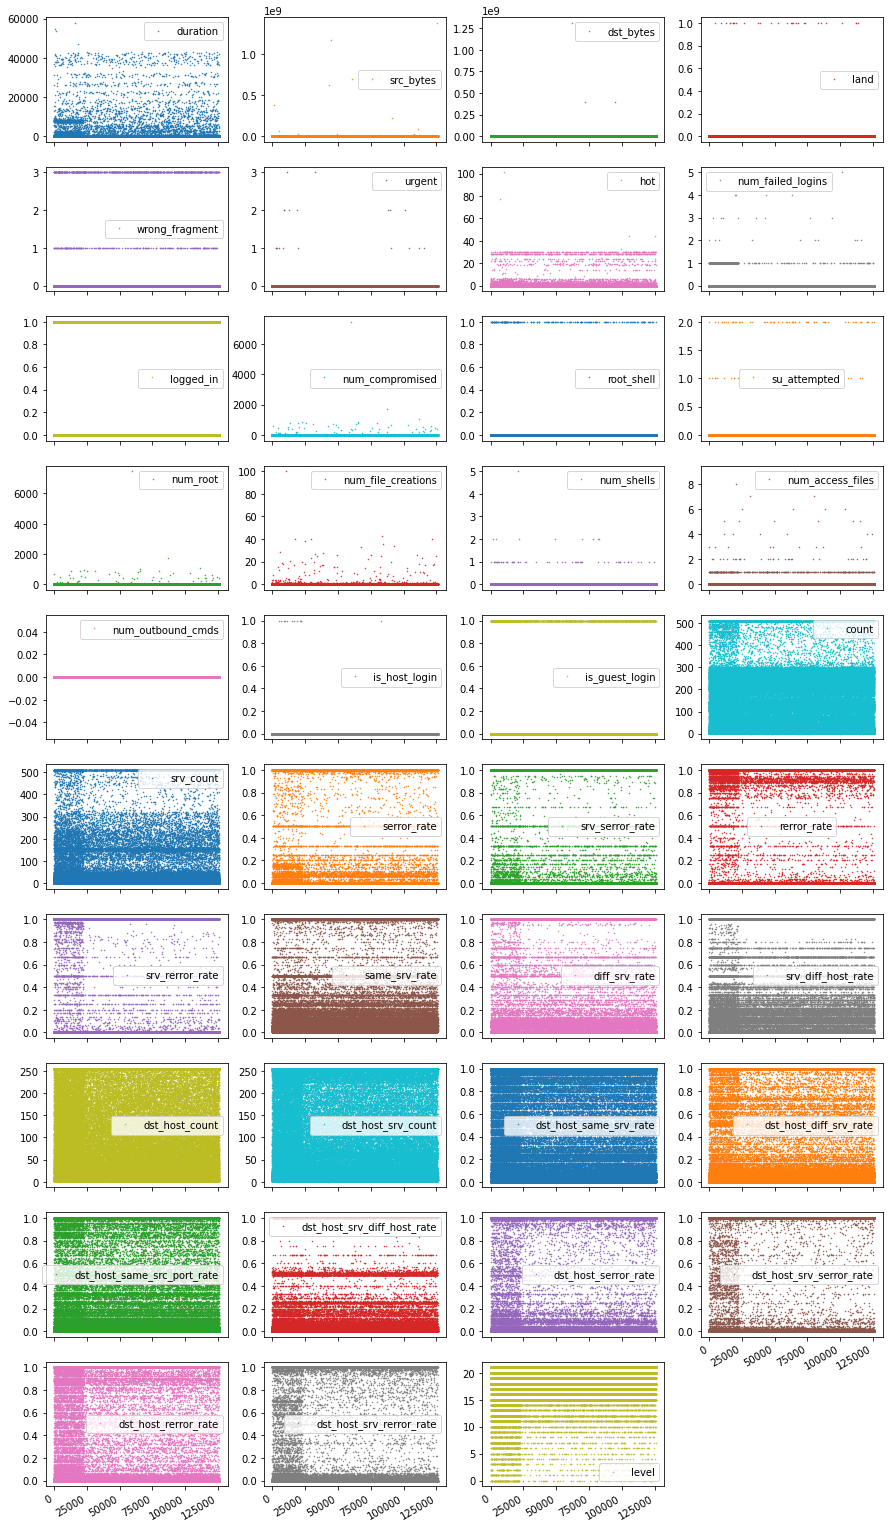

In [15]:
data.plot(lw=0,
          marker=".",
          subplots=True,
          layout=(-1, 4),
          figsize=(15, 30),
          markersize=1);

## Características no numéricas
#### Exploramos la distribución de los datos por columna alfanumérico

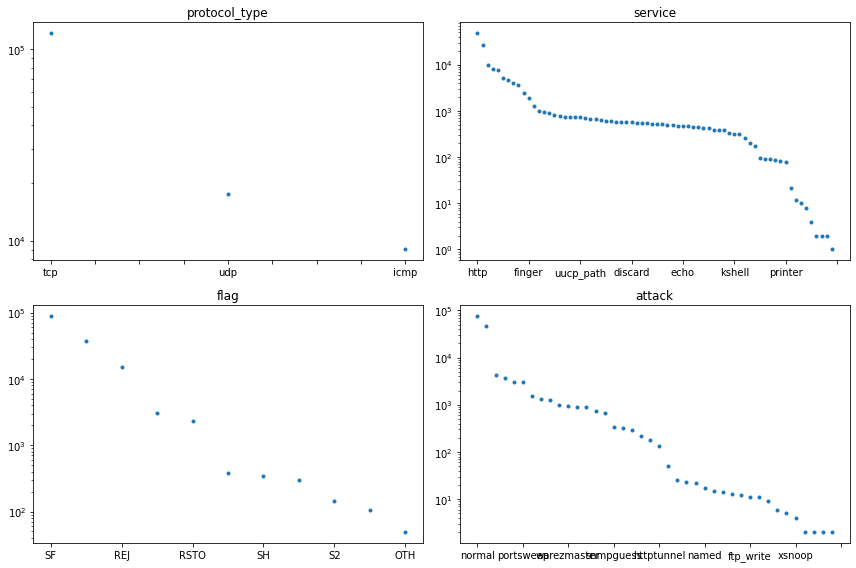

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
df_non_numerical = data.select_dtypes(exclude=["number"])

for col, ax in zip(df_non_numerical.columns, axes.ravel()):
    df_non_numerical[col].value_counts().plot(
        logy=True, title=col, lw=0, marker=".", ax=ax)
    
plt.tight_layout();

 ## Distribución de características
 #### Vamos a observar la cantidad de datos únicos por columna

In [17]:
cantidadDeCaracteristicasPorColumna = {}

for c in columnas:
    if c in data.columns.values:
        cantidadDeCaracteristicasPorColumna[c] = len(data[c].unique())
    
cantidadDeCaracteristicasPorColumna 

{'duration': 3424,
 'protocol_type': 3,
 'service': 70,
 'flag': 11,
 'src_bytes': 3601,
 'dst_bytes': 10401,
 'land': 2,
 'wrong_fragment': 3,
 'urgent': 4,
 'hot': 29,
 'num_failed_logins': 6,
 'logged_in': 2,
 'num_compromised': 96,
 'root_shell': 2,
 'su_attempted': 3,
 'num_root': 91,
 'num_file_creations': 36,
 'num_shells': 4,
 'num_access_files': 10,
 'num_outbound_cmds': 1,
 'is_host_login': 2,
 'is_guest_login': 2,
 'count': 512,
 'srv_count': 512,
 'serror_rate': 99,
 'srv_serror_rate': 94,
 'rerror_rate': 98,
 'srv_rerror_rate': 95,
 'same_srv_rate': 101,
 'diff_srv_rate': 101,
 'srv_diff_host_rate': 87,
 'dst_host_count': 256,
 'dst_host_srv_count': 256,
 'dst_host_same_srv_rate': 101,
 'dst_host_diff_srv_rate': 101,
 'dst_host_same_src_port_rate': 101,
 'dst_host_srv_diff_host_rate': 75,
 'dst_host_serror_rate': 101,
 'dst_host_srv_serror_rate': 101,
 'dst_host_rerror_rate': 101,
 'dst_host_srv_rerror_rate': 101,
 'attack': 40,
 'level': 22}

#### Se procede a eliminar columnas que no aportan al análisis, por contener un único valor

In [18]:
eliminar = []

for x in cantidadDeCaracteristicasPorColumna:
    if cantidadDeCaracteristicasPorColumna[x] == 1:
        eliminar.append(x)

if eliminar in data.columns.values:
    data = data.drop(eliminar, axis=1)    
    
print("Columnas eliminadas porque solo tienen una característica {0} y cantidad de columnas eliminadas {1}"
      .format(eliminar, len(eliminar)))        

Columnas eliminadas porque solo tienen una característica ['num_outbound_cmds'] y cantidad de columnas eliminadas 1


##### Vamos a resetear los indices del dataset

In [19]:
data = data.reset_index()
del data['index']

## Convertimos a numérico la columna de definición de ataque o no
#### 0 - normal y 1- Ataque

In [20]:
data_attack_flag = data.attack.map(lambda a: 0 if a == 'normal' else 1)

#### Eliminamos la columna de ataques y nivel de gravedad de la entrada del trafico, ambas son definidas como etiquetas

In [21]:
columnaAtaque = ['attack','level']
if columnaAtaque[0] in data.columns.values:    
    data = data.drop(columnaAtaque, axis=1)

Ver con el equipo: https://towardsdatascience.com/a-deeper-dive-into-the-nsl-kdd-data-set-15c753364657

### Vamos a visualizar la cantidad de valores únicos por columna tipo numéricas

<AxesSubplot:title={'center':'Valores Únicos por Características'}>

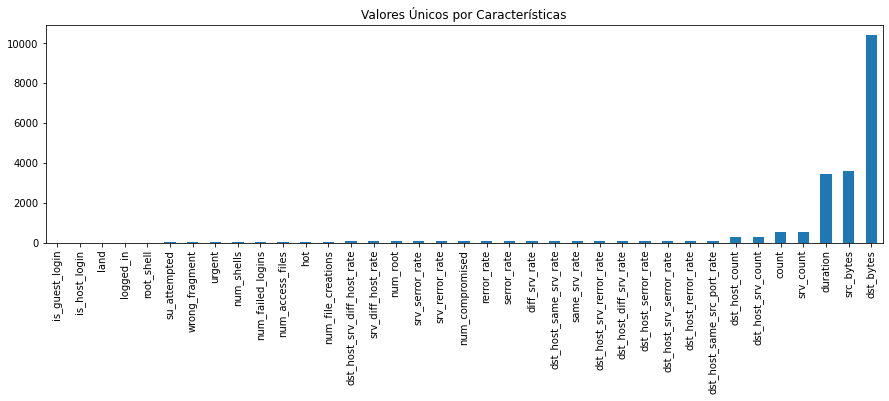

In [22]:
valoresUnicos = data.select_dtypes(include="number").nunique().sort_values()
valoresUnicos.plot.bar(logy=False, figsize=(15,4),title="Valores Únicos por Características")

### Explorando la distribución de la columan duración

In [23]:
data.groupby(['duration']).size().reset_index().rename(columns={0:'count'}).head(10)

,duration,count
0,0,134363
1,1,2576
2,2,946
3,3,677
4,4,890
5,5,444
6,6,228
7,7,142
8,8,113
9,9,107


##### Nota: podemos observar, que las columnas que tienen mayor cantidad de características superan las 2000 características

## Visualizando las caracterizaras por columnas y respaldando para luego convertir cada valor no numérico

In [24]:
listaConCaracterizaciones = {}
for c in data.columns:
    listaConCaracterizaciones[c] = data[c].unique()   
listaConCaracterizaciones    

{'duration': array([    0,     2,     1, ...,  5430, 11680,   679]),
 'protocol_type': array(['tcp', 'icmp', 'udp'], dtype=object),
 'service': array(['private', 'ftp_data', 'eco_i', 'telnet', 'http', 'smtp', 'ftp',
        'ldap', 'pop_3', 'courier', 'discard', 'ecr_i', 'imap4',
        'domain_u', 'mtp', 'systat', 'iso_tsap', 'other', 'csnet_ns',
        'finger', 'uucp', 'whois', 'netbios_ns', 'link', 'Z39_50',
        'sunrpc', 'auth', 'netbios_dgm', 'uucp_path', 'vmnet', 'domain',
        'name', 'pop_2', 'http_443', 'urp_i', 'login', 'gopher', 'exec',
        'time', 'remote_job', 'ssh', 'kshell', 'sql_net', 'shell',
        'hostnames', 'echo', 'daytime', 'pm_dump', 'IRC', 'netstat', 'ctf',
        'nntp', 'netbios_ssn', 'tim_i', 'supdup', 'bgp', 'nnsp', 'rje',
        'printer', 'efs', 'X11', 'ntp_u', 'klogin', 'tftp_u', 'red_i',
        'urh_i', 'http_8001', 'aol', 'http_2784', 'harvest'], dtype=object),
 'flag': array(['REJ', 'SF', 'RSTO', 'S0', 'RSTR', 'SH', 'S3', 'S2', 'S1'

#### Vamos a convertir las columnas de tipo alfanumérico en numéricas, mediante el indice del arreglo generado anteriormente

In [25]:
columnas = data.columns.values

data_player = data.copy() ## Copiamos el dataset que tenemos limpio, con el fin de poder reutilizar luego

for col in columnas:
    if data_player.dtypes[col] == "object":
        data_player["{0}_".format(col)] = [ listaConCaracterizaciones[col].tolist().index(i) 
                                           for i in data_player[col]]                            

#### Limpiamos el nuevo dataset data_player, quitando las columnas de tipo alfanumérico

In [26]:
columnasNumericas = [ i for i in data_player.columns.values if (data_player.dtypes[i] == "int64")  ]
print("Obtenemos cantidad de columnas numéricas {0}".format(len(columnasNumericas)))

Obtenemos cantidad de columnas numéricas 25


In [27]:
data_player = data_player[columnasNumericas]

## Iniciamos con el proceso de análisis del dataset limpio con solo datos numéricos
##### Creamos una copia del dataset dataPlayer

In [28]:
dataDeTrabajo = data_player.copy()


##### Mostramos matriz de correlación

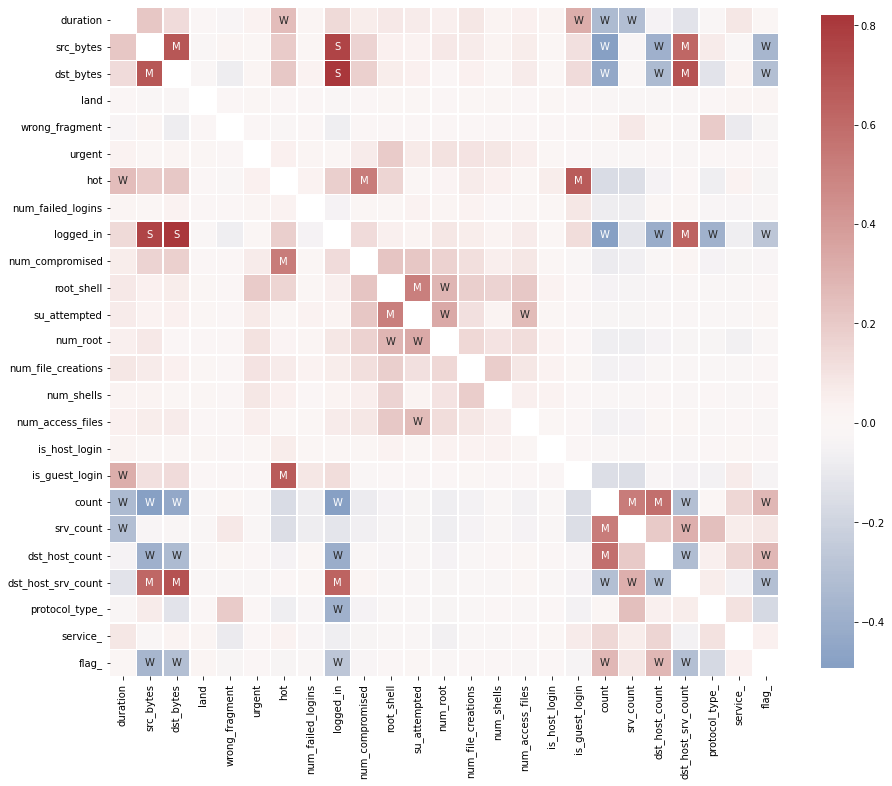

In [29]:

datosCorrelacionados = dataDeTrabajo.corr(method="spearman")


labels = np.where(np.abs(datosCorrelacionados)>0.75, "S",
                  np.where(np.abs(datosCorrelacionados)>0.5, "M",
                           np.where(np.abs(datosCorrelacionados)>0.25, "W", "")))


plt.figure(figsize=(15, 15))
sns.heatmap(datosCorrelacionados, mask=np.eye(len(datosCorrelacionados)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

In [30]:
matrizDeCorrelacion = np.tril(np.ones(datosCorrelacionados.shape), k=-1).astype("bool")

columnasMayorCorrelacionadas = datosCorrelacionados.where(matrizDeCorrelacion).stack().sort_values(ascending=False)

display(columnasMayorCorrelacionadas.head(20))

logged_in           dst_bytes         0.819930
                    src_bytes         0.764560
dst_host_srv_count  dst_bytes         0.703222
dst_bytes           src_bytes         0.688996
is_guest_login      hot               0.666742
dst_host_srv_count  logged_in         0.638377
                    src_bytes         0.619712
dst_host_count      count             0.587522
srv_count           count             0.528756
num_compromised     hot               0.524521
su_attempted        root_shell        0.517251
num_root            su_attempted      0.335212
is_guest_login      duration          0.315596
dst_host_srv_count  srv_count         0.307156
num_root            root_shell        0.282460
flag_               count             0.279276
                    dst_host_count    0.278590
num_access_files    su_attempted      0.258824
hot                 duration          0.250816
protocol_type_      srv_count         0.249671
dtype: float64

In [31]:
dataDeTrabajo.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,num_access_files,is_host_login,is_guest_login,count,srv_count,dst_host_count,dst_host_srv_count,protocol_type_,service_,flag_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,229,10,255,10,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,136,1,255,1,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,...,0,0,0,1,1,134,86,0,1,1
3,0,20,0,0,0,0,0,0,0,0,...,0,0,0,1,65,3,57,1,2,1
4,1,0,15,0,0,0,0,0,0,0,...,0,0,0,1,8,29,86,0,3,2


## Función para generar colores aleatorios

In [32]:
def generarColoresParaGraficar(cantidad = 6):
    Ncolors = range(1, (cantidad + 1))
    color_theme = np.array([ ("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))  for i in Ncolors])
    
    return color_theme

### Creando cluster de los datos, aunque los datos ya están etiquetado, esto con el fin de explorar el comportamiento

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random

data_km = dataDeTrabajo.copy()

##### Vamos a escalar los datos, para ello vamos a entrenar nuestro algoritmo de escalado y luego procedemos a escalar

In [34]:
scaler=StandardScaler()
scaler.fit(data_km) 
data_km=scaler.transform(data_km)

##### Observamos los datos escalados

In [35]:
df_escalado = pd.DataFrame(data_km, columns=dataDeTrabajo.columns.values)
df_escalado.head(6)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,num_access_files,is_host_login,is_guest_login,count,srv_count,dst_host_count,dst_host_srv_count,protocol_type_,service_,flag_
0,-0.112716,-0.007450,-0.004623,-0.014004,-0.085118,-0.010425,-0.09417,-0.059956,-0.823833,-0.011492,...,-0.042215,-0.009008,-0.111865,1.252482,-0.239937,0.722302,-0.983668,-0.446121,-0.725617,-1.316688
1,-0.112716,-0.007450,-0.004623,-0.014004,-0.085118,-0.010425,-0.09417,-0.059956,-0.823833,-0.011492,...,-0.042215,-0.009008,-0.111865,0.454382,-0.360316,0.722302,-1.064599,-0.446121,-0.725617,-1.316688
2,-0.111905,-0.005055,-0.004623,-0.014004,-0.085118,-0.010425,-0.09417,-0.059956,-0.823833,-0.011492,...,-0.042215,-0.009008,-0.111865,-0.704151,-0.360316,-0.506077,-0.300243,-0.446121,-0.647314,-0.454322
3,-0.112716,-0.007447,-0.004623,-0.014004,-0.085118,-0.010425,-0.09417,-0.059956,-0.823833,-0.011492,...,-0.042215,-0.009008,-0.111865,-0.704151,0.495715,-1.835974,-0.561023,1.050565,-0.569011,-0.454322
4,-0.112310,-0.007450,-0.004619,-0.014004,-0.085118,-0.010425,-0.09417,-0.059956,-0.823833,-0.011492,...,-0.042215,-0.009008,-0.111865,-0.704151,-0.266688,-1.572025,-0.300243,-0.446121,-0.490708,0.408045
5,-0.112716,-0.007401,-0.000712,-0.014004,-0.085118,-0.010425,-0.09417,-0.059956,1.213838,-0.011492,...,-0.042215,-0.009008,-0.111865,-0.678406,-0.320190,-0.292887,1.219478,-0.446121,-0.412405,-0.454322


In [36]:
cantidadDeCluster = 2 ## Observamos que tan bien separa los datos en normales y ataques, creando dos cluster

In [37]:
kmeans = KMeans(n_clusters=cantidadDeCluster, random_state=0, max_iter = 300)

kmeans_lb = kmeans.fit_predict(data_km)

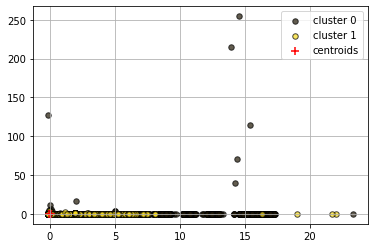

In [38]:
fig, ax = plt.subplots(1,1)

colors = generarColoresParaGraficar(cantidadDeCluster)#['m','g']
 
for i in range(cantidadDeCluster):  
  plt.scatter(
    data_km[kmeans_lb == i, 0], data_km[kmeans_lb == i, 1],
    s=30, c=colors[i], alpha=0.7,
    marker='o', edgecolor='black',
    label='cluster {}'.format(i)
  )

# ploteamos los centroides
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=50, marker='+',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [39]:
cantidadDeDatosQueNoCoinciden = (kmeans_lb == data_attack_flag)
print("Total registros: {0} - Coinciden {1} - No coinciden: {2}".format(
len(cantidadDeDatosQueNoCoinciden),
len(cantidadDeDatosQueNoCoinciden[cantidadDeDatosQueNoCoinciden == True]),
len(cantidadDeDatosQueNoCoinciden[cantidadDeDatosQueNoCoinciden == False])
))

Total registros: 147907 - Coinciden 28293 - No coinciden: 119614


## Análisis PCA

## Graficando nuestros datos con 2 dimensiones de nuestro dataset

In [40]:
pca = PCA(n_components=2) 
pca.fit(data_km) 

reduced_data2 = pca.transform(data_km) 

explained_variance = [(i,np.round(pca.explained_variance_ratio_[i],4)) for i in range(len(pca.explained_variance_ratio_))]

print( "Las dos dimensiones explican el {0}% de los datos".format(((explained_variance[0][1] + explained_variance[1][1])*100)) )

Las dos dimensiones explican el 22.57% de los datos


In [41]:
pca_graficar = pd.DataFrame(data = reduced_data2, 
                            columns=['PCA1','PCA2']) 

pca_graficar['labels'] = data_attack_flag.values

pca_graficar.head(5)

,PCA1,PCA2,labels
0,-0.875141,0.367127,1
1,-0.555537,0.219929,1
2,0.355655,-0.237227,0
3,0.353404,-0.286190,1
4,0.446637,-0.261403,1


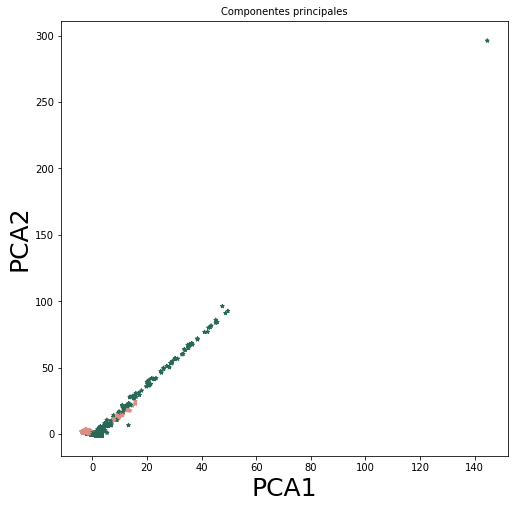

In [42]:
explained_variance = [(i,np.round(pca.explained_variance_ratio_[i],4)) for i in range(len(pca.explained_variance_ratio_))]

color_theme = generarColoresParaGraficar(cantidad = 2)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PCA1', fontsize = 25)
ax.set_ylabel('PCA2', fontsize = 25)
ax.set_title('Componentes principales', fontsize = 10)

ax.scatter(x = pca_graficar.PCA1, y = pca_graficar.PCA2, 
           c=color_theme[pca_graficar.labels], 
           marker='*', s=15)
plt.show()


## Graficando nuestros datos con 3 dimensiones de nuestro dataset

In [43]:
from mpl_toolkits.mplot3d import Axes3D

In [44]:
pca = PCA(n_components=3) 
pca.fit(data_km) # obtener los componentes principales
reduced_data3 = pca.transform(data_km) # convertimos nuestros datos con las nuevas dimensiones de PCA

pca_graficar3 = pd.DataFrame(data = reduced_data3, 
                            columns=['PCA1','PCA2','PCA3']) 

pca_graficar3['labels'] = data_attack_flag.values

color_theme = generarColoresParaGraficar(cantidad = 3)

explained_variance = [(i,np.round(pca.explained_variance_ratio_[i],4)) for i in range(len(pca.explained_variance_ratio_))]

print( "Las dos dimensiones explican el {0}% de los datos".format(round((explained_variance[0][1] + explained_variance[1][1])*100,2)) )


Las dos dimensiones explican el 22.56% de los datos


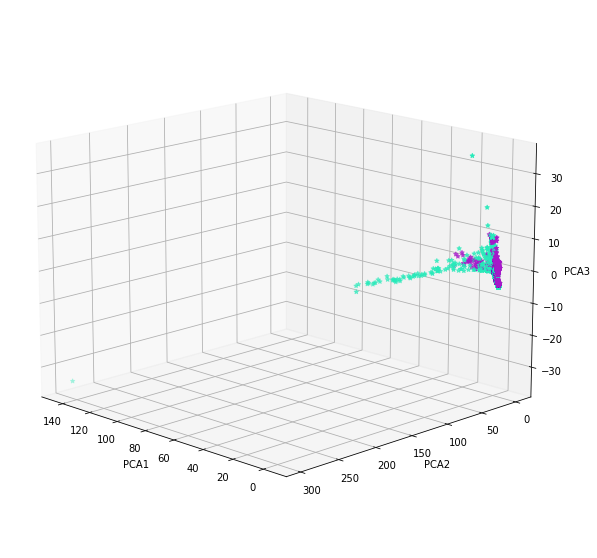

In [45]:
fig = plt.figure(figsize=(10, 10))#1, figsize=(12, 12)

plt.clf()
ax = fig.add_subplot(111,projection = '3d',elev=15, azim=135) 
plt.cla()

ax.scatter(pca_graficar3.PCA1, pca_graficar3.PCA2, pca_graficar3.PCA3, 
           c=color_theme[pca_graficar3.labels], marker='*', 
           cmap=plt.cm.nipy_spectral)    

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')


plt.show()

#### Procedemos a reducir las dimensiones del dataset ya limpio, con el fin de basar la construcción de los modelos con las columnas que mejor explican los datos, vamos a usar las columnas que expliquen nuestros datos según PCA, hasta en un 90%

In [46]:
def construirYTransformarDatosConPCA(data_km_, porcentaje_ = 90):    
    
    porcentaje_ = round((porcentaje_ / 100),2)    
    pca_=PCA(porcentaje_)
    pca_.fit(data_km)
    
    reduced_data = pca_.transform(data_km_)
    explained_variance = [(i, "{0}%".format(np.round((pca_.explained_variance_ratio_[i] * 100),2)))   for i in range(len(pca_.explained_variance_ratio_))]
    
    return pca_, reduced_data, explained_variance

#### Entrenamos y creamos nuestro nuevo dataset con las nuevas dimensiones

In [47]:
pca_, reduced_data, explained_variance = construirYTransformarDatosConPCA(data_km, porcentaje_ = 90) 
print(explained_variance)    

[(0, '11.6%'), (1, '10.97%'), (2, '7.5%'), (3, '6.64%'), (4, '5.35%'), (5, '4.63%'), (6, '4.29%'), (7, '4.1%'), (8, '4.07%'), (9, '4.01%'), (10, '4.0%'), (11, '3.98%'), (12, '3.95%'), (13, '3.75%'), (14, '3.57%'), (15, '3.26%'), (16, '2.95%'), (17, '2.54%')]


In [48]:
print("El PCA inicial nos genera un dataset con las siguientes dimensiones-> filas {0} columnas {1}, el dataset original tiene-> filas {2} columnas {3}, reduciendo nuestro dataset en {4} columnas".format( 
    reduced_data.shape[0],  
    reduced_data.shape[1],
    data_km.shape[0],  
    data_km.shape[1],
    (data_km.shape[1] - reduced_data.shape[1]) ))

expl = pca_.explained_variance_ratio_

El PCA inicial nos genera un dataset con las siguientes dimensiones-> filas 147907 columnas 18, el dataset original tiene-> filas 147907 columnas 25, reduciendo nuestro dataset en 7 columnas


In [49]:
cantiRecomendadaDePCA = reduced_data.shape[1]
print('Podemos observar que {0} de nuestras variables generadas, explican el {1}% de nuestros datos'
      .format(cantiRecomendadaDePCA, (round(sum(expl[0:cantiRecomendadaDePCA]),4) * 100)))

Podemos observar que 18 de nuestras variables generadas, explican el 91.16% de nuestros datos


## Vamos a crear nuestros nuevos dataset de datos de entrenamiento y pruebas basados en el dataset generado por nuestro PCA

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
porcentajeDatosDePrueba = 0.20

train_, test_, train_lbl, test_lbl = train_test_split( reduced_data, 
                                                       data_attack_flag.values, 
                                                      test_size=porcentajeDatosDePrueba, 
                                                      random_state=0)

In [52]:
print("Nuestro datos de entrenamientos({0}% - Data: {1} - Etiquetas: {2}) y prueba({3}% - Data: {4} - Etiquetas: {5})".format( 
                      (100 - (porcentajeDatosDePrueba * 100)),                       
                      train_.shape,
                      train_lbl.shape,
                      (porcentajeDatosDePrueba * 100),
                      test_.shape,
                      test_lbl.shape
                      ))

Nuestro datos de entrenamientos(80.0% - Data: (118325, 18) - Etiquetas: (118325,)) y prueba(20.0% - Data: (29582, 18) - Etiquetas: (29582,))


## Función para mostrar matriz de confusión

In [53]:
from sklearn.metrics import confusion_matrix, classification_report,  precision_recall_fscore_support, roc_auc_score

LABELS = ["Normal","Anomalia"]
def mostrar_resultados(y_test, pred_y, title = "Matriz de confusión"):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title(title)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

## Creando Modelos de clasificación basado en el dataset resultado del PCA 

In [54]:
from sklearn.linear_model import LogisticRegression

## Regresión Logística

In [55]:

def ConstruirYEntrenarRegresionLogistica(_c = 1.0, _solver = 'lbfgs', _max_iter = 350, _multi_class ='multinomial'):    
    start_time = time()
    logisticRegr = LogisticRegression(C=_c, solver=_solver, max_iter=_max_iter, multi_class=_multi_class)
    logisticRegr.fit(train_, train_lbl)
    elapsed_time = time() - start_time
    print("Tiempo de ejecución: ",convert(elapsed_time))
    
    return logisticRegr    


In [56]:
logisticRegr = ConstruirYEntrenarRegresionLogistica()

Tiempo de ejecución:  0:00:01


In [57]:
def ejecutarRegresionLogistica(logisticRegr, valorAComparar = 8): 
    
    
    print("Registro a comparar {2} predicción {0}, valor real {1}".format(
                                                  logisticRegr.predict(test_[valorAComparar].reshape(1,-1)),
                                                  test_lbl[valorAComparar],
                                                  valorAComparar))
    print("----------------------------------------------")
    print("score de entrenamiento: {0}%".format(round((logisticRegr.score(train_, train_lbl) * 100),2)))
    print("score de pruebas: {0}%".format(round((logisticRegr.score(test_, test_lbl) * 100),2)))

    y_pred = logisticRegr.predict(test_)

    mostrar_resultados(test_lbl, y_pred, "Matriz de confusión - > Regresión Logística")    

Registro a comparar 8 predicción [1], valor real 1
----------------------------------------------
score de entrenamiento: 88.83%
score de pruebas: 88.9%


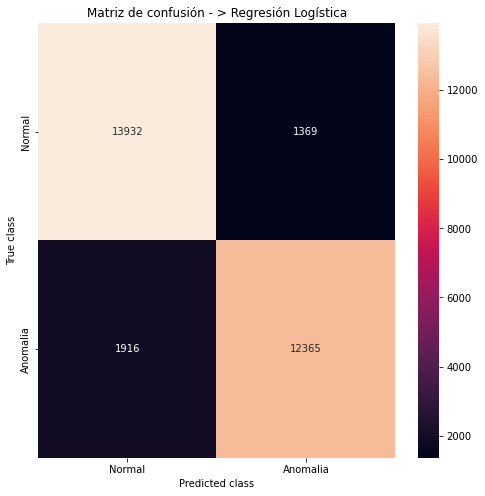

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     15301
           1       0.90      0.87      0.88     14281

    accuracy                           0.89     29582
   macro avg       0.89      0.89      0.89     29582
weighted avg       0.89      0.89      0.89     29582



In [58]:
ejecutarRegresionLogistica(logisticRegr)

### Probando con todos los datos

In [59]:
def probarModeloDeRegresion(logisticRegr, datosCompletos, datosCompletoslbl):
    
    y_pred = logisticRegr.predict(datosCompletos)
    mostrar_resultados(datosCompletoslbl, y_pred, "Matriz de confusión - > Regresión Logística")
    

Nuevas dimensiones del dataset completo (147907, 18) etiquetas (147907,)


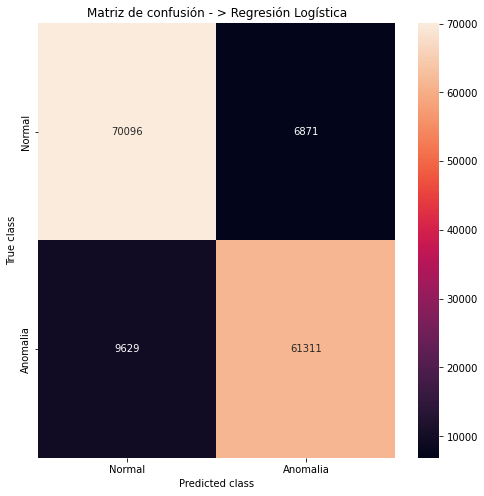

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     76967
           1       0.90      0.86      0.88     70940

    accuracy                           0.89    147907
   macro avg       0.89      0.89      0.89    147907
weighted avg       0.89      0.89      0.89    147907



In [60]:
datosCompletos = np.concatenate((train_, test_), axis=0)
datosCompletoslbl = np.concatenate((train_lbl, test_lbl), axis=0)

print("Nuevas dimensiones del dataset completo {0} etiquetas {1}".format(datosCompletos.shape, datosCompletoslbl.shape))

probarModeloDeRegresion(logisticRegr, datosCompletos, datosCompletoslbl)


## Random Forest 

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
def construiYEntrenarModeloRandomForest():
    start_time = time()
    model = RandomForestClassifier(n_estimators=100, 
                                   class_weight="balanced",
                                   bootstrap = True,
                                   max_features = 'sqrt', 
                                   verbose=1, 
                                   max_depth=6,
                                   oob_score=True, 
                                   random_state=50, 
                                   n_jobs = 10)

    
    model.fit(train_, train_lbl)
    elapsed_time = time() - start_time
    print("Tiempo de ejecución: ",convert(elapsed_time))
    return model


In [63]:
model = construiYEntrenarModeloRandomForest()

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.3s finished


Tiempo de ejecución:  0:00:02


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


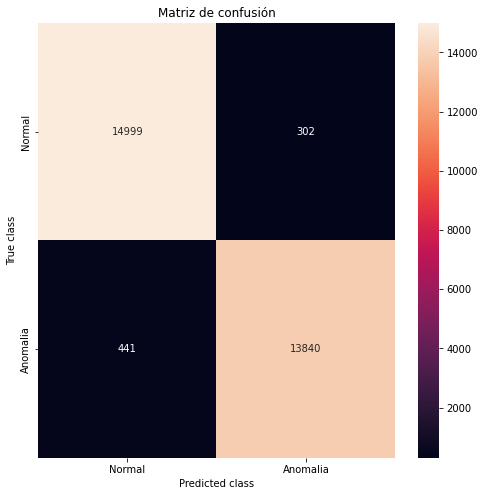

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     15301
           1       0.98      0.97      0.97     14281

    accuracy                           0.97     29582
   macro avg       0.98      0.97      0.97     29582
weighted avg       0.97      0.97      0.97     29582

Calculo de roc auc:  0.9746912687317132


In [64]:
pred_y = model.predict(test_)
mostrar_resultados(test_lbl, pred_y)

roc_value = roc_auc_score( test_lbl, pred_y)
print("Calculo de roc auc: ", roc_value)

### Probando con todos los datos

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


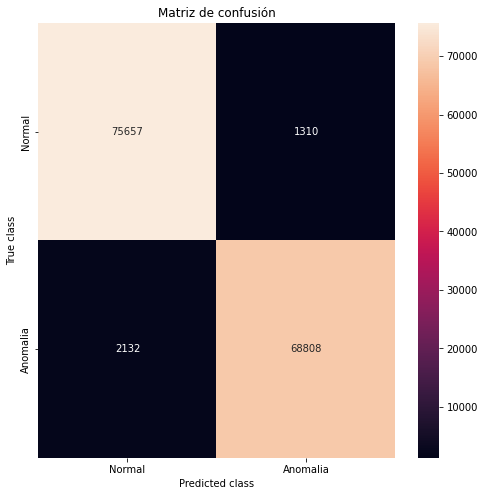

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     76967
           1       0.98      0.97      0.98     70940

    accuracy                           0.98    147907
   macro avg       0.98      0.98      0.98    147907
weighted avg       0.98      0.98      0.98    147907



In [65]:
pred_y = model.predict(datosCompletos)

mostrar_resultados(datosCompletoslbl, pred_y)

## Máquinas de Vector Soporte (SVM)

In [66]:
from sklearn import svm

In [67]:
def EjecutarMaquinaDeSoporte(kenel = 'linear', decision_function_shape='ovo',degree=3, gamma='auto'):
    start_time = time()
    modelo = svm.SVC(kernel= kenel, 
                     degree=degree, 
                     C=1, 
                     gamma=gamma,
                     decision_function_shape= decision_function_shape).fit(train_, train_lbl)
    
    prediccion_ = modelo.predict(test_)
    presicion_ = modelo.score(test_, test_lbl)
    
    print("Precisión usando el kernel {0}: {1}".format(kenel, presicion_))
    
    mostrar_resultados(test_lbl, prediccion_, "Matriz de confusión - > {0}_pred".format(kenel))
    elapsed_time = time() - start_time
    print("Tiempo de ejecución: ",convert(elapsed_time))

Precisión usando el kernel linear: 0.8904401325130147


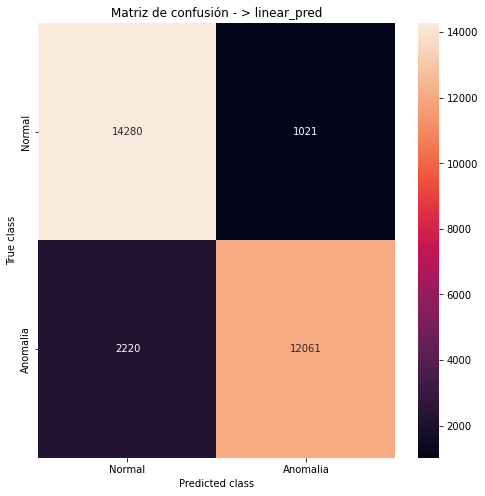

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     15301
           1       0.92      0.84      0.88     14281

    accuracy                           0.89     29582
   macro avg       0.89      0.89      0.89     29582
weighted avg       0.89      0.89      0.89     29582

Tiempo de ejecución:  0:02:25


In [68]:
EjecutarMaquinaDeSoporte()

EjecutarMaquinaDeSoporte(kenel = 'poly')

EjecutarMaquinaDeSoporte(kenel = 'sigmoid')

EjecutarMaquinaDeSoporte(kenel = 'rbf',gamma=1)

### Nota:
##### Este modelo es unicamente utilizado con el fin de probar diferentes algoritmo de estudio, pero podemos notar que como tal es un algoritmo que con muchos datos es lento su entrenamiento, por lo que, en nuestro caso de estudio, no lo recomendamos como modelo para ser usado en producción como parte de la solución de predicción, ya que podemos notar que a pesar de que arroja buenos resultados en predicciones, sus tiempos de entrenamiento son bastantes lentos, en ocasiones con tiempos superiores a los 2 minutos

## Árboles de decisión

In [69]:
from sklearn.tree import DecisionTreeClassifier

def ejecutarArbolDeClasificacion():
    start_time = time()
    clf = DecisionTreeClassifier()
    clf = clf.fit(train_, train_lbl)
    train_acc = clf.score(train_, train_lbl) 
    test_acc = clf.score(test_, test_lbl) 
    y_pred = clf.predict(test_) 
    elapsed_time = time() - start_time
    print("Tiempo de ejecución: ",convert(elapsed_time))
    print("-----------------------------------------------------------")
    print("score train {0} score test {1}".format(train_acc,test_acc))
    mostrar_resultados(test_lbl, y_pred, "Matriz de confusión - > DecisionTreeClassifier")

Tiempo de ejecución:  0:00:02
-----------------------------------------------------------
score train 0.9990534544686246 score test 0.9866472855114596


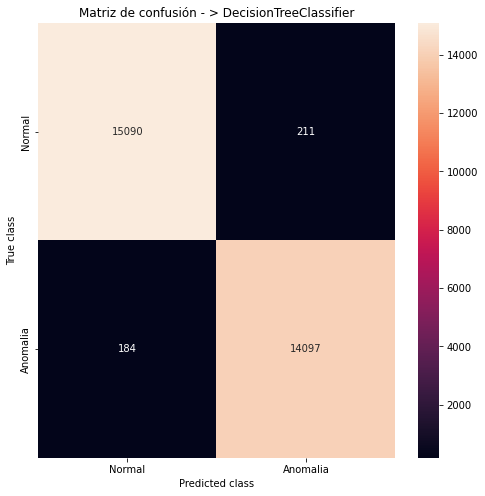

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15301
           1       0.99      0.99      0.99     14281

    accuracy                           0.99     29582
   macro avg       0.99      0.99      0.99     29582
weighted avg       0.99      0.99      0.99     29582



In [70]:
ejecutarArbolDeClasificacion()

## Creando una red neuronal

In [71]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

### Comparamos las épocas del entrenamientos con el siguiente funciones (precisión y perdida)

In [72]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

### Método para construir nuestra red neuronal

In [73]:
def construirModelo(tipoActivacion = 'sigmoid', 
                    kernel='glorot_uniform',
                    bias = 'zeros', 
                    valoresCapas = [32,64,128,64], 
                    tipoCapaSalida = 'softmax',
                    activarBatchNormalizacion = False,
                    dropout = None,
                    cantidadCapasDeEntrada = 19,
                    cantidadCapasDeSalida = 2):        
    
    model = Sequential()        
    model.add(Dense(units=cantidadCapasDeEntrada,input_shape=(cantidadCapasDeEntrada,)))     
    
    if(activarBatchNormalizacion):
        model.add(BatchNormalization())  
    
    for valor in range(len(valoresCapas)):        
        model.add( Dense(valoresCapas[valor], 
                         activation=tipoActivacion, 
                         bias_initializer=bias, 
                         kernel_initializer=kernel))
        
        if(dropout):
            model.add(Dropout(dropout))             
    
    model.add( Dense(cantidadCapasDeSalida, activation=tipoCapaSalida))
    return model

### Creamos el modelo y visualizamos la red neuronal

In [74]:
def construirModeloAUsarEnreDNeuronal():
    model = construirModelo(tipoActivacion = 'ReLU', 
                            valoresCapas = [32,64,128, 128,64],
                            cantidadCapasDeEntrada=train_.shape[1])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = construirModeloAUsarEnreDNeuronal()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                342       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                608       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1

### Entrenamos la red neuronal y evaluamos nuestro modelo entrenado

In [75]:
batch_size = 64
epochs=20

history1 = model.fit(train_, train_lbl, batch_size=batch_size, epochs=epochs, validation_split = 0.2 , verbose=0)
print(model.evaluate(test_, test_lbl))

925/925 [==============================] - 1s 838us/step - loss: 0.0516 - accuracy: 0.9782
[0.05161605030298233, 0.9781962037086487]


### Se realizan predicción con el modelo entrenado, con el fin de validar su eficiencia

In [76]:
def prediccionUsandoElModelo(model, 
                             valorAComparar = 8, ## debe de dar 1
                             valorACompararContra = 0 ## debe de dar 0
                            ):

    esAnomalia = "Anomalia"
    if((test_lbl[valorAComparar] == 0)):
        esAnomalia = 'Normal'
        
    predictions = model.predict(test_[valorAComparar].reshape(1,-1))

    print("Probabilidad de no ser anomalía {0} - Probabilidad de ser anomalía {1} -> Etiqueta real {2}"
          .format(round(predictions[0][0]), round(predictions[0][1]),esAnomalia))


    esAnomalia = "Anomalia"
    if((test_lbl[valorACompararContra] == 0)):
        esAnomalia = 'Normal'
    
    predictions = model.predict(test_[valorACompararContra].reshape(1,-1))
    print("Probabilidad de no ser anomalía {0} - Probabilidad de ser anomalía {1} -> Etiqueta real {2}"
          .format(round(predictions[0][0]), 
                  round(predictions[0][1]), 
                  esAnomalia))


In [77]:
prediccionUsandoElModelo(model)
prediccionUsandoElModelo(model, 72, 320)
prediccionUsandoElModelo(model, 107, 124)
prediccionUsandoElModelo(model, 678, 560)

Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal


### Visualización del entrenamiento por épocas

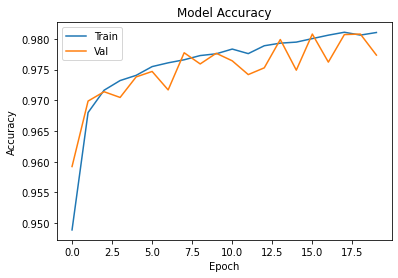

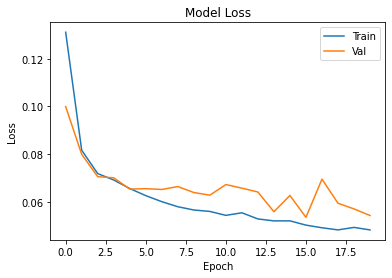

In [78]:
plot_acc(history1)
plot_loss(history1)

## Probando nuestro modelo, con solo datos Anómalos y No Anómalos

In [79]:
def crearDatasetNuevo(dt_p,lb_p):
    df_devolver = pd.DataFrame(dt_p, columns=dataDeTrabajo.columns.values)
    df_devolver['labels'] = lb_p.values
    
    return df_devolver

### Creamos nuestros dataset para probar con solo datos Anómalos y No Anómalos

In [80]:
df_EntrenarRedNeuronal = crearDatasetNuevo(data_km, data_attack_flag)

df_EntrenarRedNeuronalAnomalia = df_EntrenarRedNeuronal[ df_EntrenarRedNeuronal['labels'] == 1]
df_EntrenarRedNeuronalNoAnomalia = df_EntrenarRedNeuronal[ df_EntrenarRedNeuronal['labels'] == 0]

df_EntrenarRedNeuronalAnomalia_lb = df_EntrenarRedNeuronalAnomalia['labels']
df_EntrenarRedNeuronalNoAnomalia_lb = df_EntrenarRedNeuronalNoAnomalia['labels']

df_EntrenarRedNeuronalAnomalia = df_EntrenarRedNeuronalAnomalia.drop(['labels'], axis=1)

df_EntrenarRedNeuronalNoAnomalia = df_EntrenarRedNeuronalNoAnomalia.drop(['labels'], axis=1)

df_EntrenarRedNeuronal = df_EntrenarRedNeuronal.drop(['labels'], axis=1)

print("Cantidad de datos anómalos: {0} - Cantidad de datos NO anómalos {1}".format(df_EntrenarRedNeuronalAnomalia.shape[0],
                                                                                   df_EntrenarRedNeuronalNoAnomalia.shape[0])
     )

Cantidad de datos anómalos: 70940 - Cantidad de datos NO anómalos 76967


#### Aplicamos transformación de nuestros datos, para reducirlo bajo el mismo entrenamiento usado en el ultimo PCA

In [81]:
reduced_dataAnomalias = pca_.transform(df_EntrenarRedNeuronalAnomalia)  ##transformando dataset anomalías

reduced_dataNoAnomalias = pca_.transform(df_EntrenarRedNeuronalNoAnomalia) ##transformando dataset no anomalías

reduced_ProbarRedNeuronalTotalDatos = pca_.transform(df_EntrenarRedNeuronal) ##transformando todo el dataset

##### Vamos a evaluar nuestro modelo entrenado anteriormente, con solo los datos anómalos y no anómalos, para verificar su eficiencia en ambos escenarios

In [82]:
print("Evaluamos con todos los datos", model.evaluate(reduced_dataNoAnomalias, df_EntrenarRedNeuronalNoAnomalia_lb))
print("Evaluamos con solo datos No Anómalos", model.evaluate(reduced_dataNoAnomalias, df_EntrenarRedNeuronalNoAnomalia_lb))
print("Evaluamos con solo datos Anómalos", model.evaluate(reduced_dataAnomalias, df_EntrenarRedNeuronalAnomalia_lb))

2406/2406 [==============================] - 2s 829us/step - loss: 0.0410 - accuracy: 0.9837
Evaluamos con todos los datos [0.04095930978655815, 0.9837203025817871]
2406/2406 [==============================] - 2s 837us/step - loss: 0.0410 - accuracy: 0.9837
Evaluamos con solo datos No Anómalos [0.04095930978655815, 0.9837203025817871]
2217/2217 [==============================] - 2s 823us/step - loss: 0.0582 - accuracy: 0.9746
Evaluamos con solo datos Anómalos [0.058206915855407715, 0.9746264219284058]


In [83]:
prediccionUsandoElModelo(model)
prediccionUsandoElModelo(model, 72, 320)
prediccionUsandoElModelo(model, 107, 124)
prediccionUsandoElModelo(model, 678, 560)

Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal


#### Vamos a evaluar nuestro modelo con datos con tiempos menores o iguales a 2 segundos de tiempo

In [84]:
def contruirNuevoModeloDeAcuerdoAlTiempoDeDuracion(tiempoDuracion_ = 0):
    dt_dos_sec_ = dataDeTrabajo.copy() 
    dt_dos_sec_['labels'] = data_attack_flag
    dt_dos_sec_ = dt_dos_sec_[(dt_dos_sec_['duration'] <= tiempoDuracion_)] 
    dt_dos_sec_lb_ = dt_dos_sec_['labels']
    dt_dos_sec_ = dt_dos_sec_.drop(['labels'], axis=1)
    dt_dos_sec_=scaler.transform(dt_dos_sec_)   
    return crearDatasetNuevo(dt_dos_sec_.copy() , dt_dos_sec_lb_.copy() )    

In [85]:
tiempoDuracion_ = 2

df_EntrenarRedNeuronal = contruirNuevoModeloDeAcuerdoAlTiempoDeDuracion(tiempoDuracion_)

df_EntrenarRedNeuronalAnomalia = df_EntrenarRedNeuronal[ df_EntrenarRedNeuronal['labels'] == 1]
df_EntrenarRedNeuronalNoAnomalia = df_EntrenarRedNeuronal[ df_EntrenarRedNeuronal['labels'] == 0]

df_EntrenarRedNeuronalAnomalia_lb = df_EntrenarRedNeuronalAnomalia['labels']
df_EntrenarRedNeuronalNoAnomalia_lb = df_EntrenarRedNeuronalNoAnomalia['labels']

df_EntrenarRedNeuronalAnomalia = df_EntrenarRedNeuronalAnomalia.drop(['labels'], axis=1)

df_EntrenarRedNeuronalNoAnomalia = df_EntrenarRedNeuronalNoAnomalia.drop(['labels'], axis=1)

df_EntrenarRedNeuronal = df_EntrenarRedNeuronal.drop(['labels'], axis=1)

print("Cantidad de datos anómalos: {0} - Cantidad de datos NO anómalos {1}".format(df_EntrenarRedNeuronalAnomalia.shape[0],
                                                                                   df_EntrenarRedNeuronalNoAnomalia.shape[0])
     )

Cantidad de datos anómalos: 66720 - Cantidad de datos NO anómalos 71165


In [86]:
reduced_dataAnomalias = pca_.transform(df_EntrenarRedNeuronalAnomalia)  ##transformando dataset anomalias

reduced_dataNoAnomalias = pca_.transform(df_EntrenarRedNeuronalNoAnomalia) ##transformando dataset no anomalias

reduced_ProbarRedNeuronalTotalDatos = pca_.transform(df_EntrenarRedNeuronal) ##transformando todo el dataset


In [87]:
print("Datos con tiempos menores o igual a: 2 segundos")
print("Evaluamos con todos los datos", model.evaluate(reduced_dataNoAnomalias, df_EntrenarRedNeuronalNoAnomalia_lb))
print("Evaluamos con solo datos No Anómalos", model.evaluate(reduced_dataNoAnomalias, df_EntrenarRedNeuronalNoAnomalia_lb))
print("Evaluamos con solo datos Anómalos", model.evaluate(reduced_dataAnomalias, df_EntrenarRedNeuronalAnomalia_lb))

Datos con tiempos menores o igual a: 2 segundos
2224/2224 [==============================] - 2s 814us/step - loss: 0.0373 - accuracy: 0.9849
Evaluamos con todos los datos [0.037301499396562576, 0.9848661422729492]
2224/2224 [==============================] - 2s 827us/step - loss: 0.0373 - accuracy: 0.9849
Evaluamos con solo datos No Anómalos [0.037301499396562576, 0.9848661422729492]
2085/2085 [==============================] - 2s 941us/step - loss: 0.0554 - accuracy: 0.9756
Evaluamos con solo datos Anómalos [0.055449843406677246, 0.9755695462226868]


In [88]:
prediccionUsandoElModelo(model)
prediccionUsandoElModelo(model, 72, 320)
prediccionUsandoElModelo(model, 107, 124)
prediccionUsandoElModelo(model, 678, 560)

Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal


# Construyendo nuevo datos de laboratorio

## Explorando los datos relacionados a src_bytes, dst_bytes, duration

### Creando un nuevo dataset con todas las columnas

In [175]:
data_lab = dataDeTrabajo.copy()
data_lab['labels'] = data_attack_flag
data_lab = data_lab.drop_duplicates()
print(data_lab.head(1).values)
print("cantidad de registros ", data_lab.shape[0])


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  229  10 255  10   0   0   0   1]]
cantidad de registros  135937


Creamos un nuevo dataset y eliminamos las columnas que queremos analizar

In [176]:
data_labReducir = data_lab.drop(['src_bytes','dst_bytes','duration'], axis=1)
data_labReducir.shape

(135937, 23)

Ahora que no tenemos las columnas que queremos analizar, vamos a quitar los registros duplicados y validar en cuanto se reduce nuestro dataset

In [177]:
data_labReducidoSinDuplicados = data_labReducir.drop_duplicates()
data_labReducidoSinDuplicados.shape

(102151, 23)

In [178]:
print("Podemos observar que pasamos de {} registros a {} de un total de {}, una diferencia de {} registros".format(
data_labReducir.shape[0],
data_labReducidoSinDuplicados.shape[0],
data_lab.shape[0],
(data_labReducir.shape[0] - data_labReducidoSinDuplicados.shape[0])))

Podemos observar que pasamos de 135937 registros a 102151 de un total de 135937, una diferencia de 33786 registros


Re-indexamos nuestro dataset

In [179]:
data_lab = data_lab.reset_index()
del data_lab['index']
data_lab.shape

(135937, 26)

Explorando los datos

In [180]:
def obtenerPorcentajeDeRepresentacion(cantidadDeRegistrosValorar, totalDeRegistros):
    return ((cantidadDeRegistrosValorar * 100) / totalDeRegistros)

def imprimirResultadosDeAnalisis(datoAnalizar, cantidadRegistroAValorar, totalDeRegistros, representanUnTotalDeLaMuestra):
    print("Cantidad de registros con {3} mayor a 0 {0} de {1} representan un {2}%".format(cantidadRegistroAValorar, 
                                                                 totalDeRegistros,
                                                                round(representanUnTotalDeLaMuestra,2),
                                                                datoAnalizar))

In [181]:
print("Cantidad de datos anómalos: {0} y NO anómalos {1}".format(data_lab[data_lab['labels'] == 1].shape[0],
                                                                data_lab[data_lab['labels'] == 0].shape[0]))

cantidadRegistroAValorar = data_lab[data_lab['duration'] != 0].shape[0]
representanUnTotalDeLaMuestra = obtenerPorcentajeDeRepresentacion(cantidadRegistroAValorar, data_lab.shape[0])

imprimirResultadosDeAnalisis("duración", 
                             cantidadRegistroAValorar, 
                             data_lab.shape[0], 
                             representanUnTotalDeLaMuestra) 

cantidadRegistroAValorar = data_lab[data_lab['src_bytes'] != 0].shape[0]
representanUnTotalDeLaMuestra = obtenerPorcentajeDeRepresentacion(cantidadRegistroAValorar, data_lab.shape[0])

imprimirResultadosDeAnalisis("src_bytes", 
                             cantidadRegistroAValorar, 
                             data_lab.shape[0], 
                             representanUnTotalDeLaMuestra) 


cantidadRegistroAValorar = data_lab[data_lab['dst_bytes'] != 0].shape[0]
representanUnTotalDeLaMuestra = obtenerPorcentajeDeRepresentacion(cantidadRegistroAValorar, data_lab.shape[0])

imprimirResultadosDeAnalisis("dst_bytes", 
                             cantidadRegistroAValorar, 
                             data_lab.shape[0], 
                             representanUnTotalDeLaMuestra) 

Cantidad de datos anómalos: 60818 y NO anómalos 75119
Cantidad de registros con duración mayor a 0 13281 de 135937 representan un 9.77%
Cantidad de registros con src_bytes mayor a 0 87668 de 135937 representan un 64.49%
Cantidad de registros con dst_bytes mayor a 0 69889 de 135937 representan un 51.41%


#### Podemos observar que la cantidad de registro con duración mayor a cero es una representación muy baja de registro, por lo que podríamos nuevamente entrenar nuestro modelo, sin la columna duración y nuestro modelo debería de poder predecir si es anomalía o no, sin problemas.

### Como parte del experimento, vamos a probar el modelo, reduciendo en porcentajes las columnas que representan bytes y eliminando posteriormente la columna duración.

In [182]:
def reducirPorcentualmeteColumnasBytes(reducirEnUn = 90):
    reducirEnUn = round((reducirEnUn / 100),2)
    data_lab_ = data_lab.copy()
    data_lab_['src_bytes'] = data_lab_.src_bytes.map(lambda a: 0 if a <= 0 else (a - (a* reducirEnUn ) ))
    data_lab_['dst_bytes'] = data_lab_.dst_bytes.map(lambda a: 0 if a <= 0 else (a - (a* reducirEnUn) ))
    
    return data_lab_

In [183]:
nuevosDatosLaboratorio = pd.concat([reducirPorcentualmeteColumnasBytes(), 
                           reducirPorcentualmeteColumnasBytes(reducirEnUn = 85),
                           reducirPorcentualmeteColumnasBytes(reducirEnUn = 70),
                           reducirPorcentualmeteColumnasBytes(reducirEnUn = 65),
                           reducirPorcentualmeteColumnasBytes(reducirEnUn = 55)])

data_lab_Reales = dataDeTrabajo.copy()
data_lab_Reales['labels'] = data_attack_flag

nuevosDatosLaboratorio = pd.concat([data_lab_Reales, nuevosDatosLaboratorio])

nuevosDatosLaboratorio = nuevosDatosLaboratorio.drop(['duration'], axis=1)

nuevosDatosLaboratorio = nuevosDatosLaboratorio.drop_duplicates()

nuevosLabels = nuevosDatosLaboratorio['labels']
nuevosDatosLaboratorio = nuevosDatosLaboratorio.drop(['labels'], axis=1)

nuevosDatosLaboratorio = nuevosDatosLaboratorio.reset_index()
del nuevosDatosLaboratorio['index']

In [184]:
print( "Total de registros con datos nuevos generados {0} labels {1} y cantidad datos originales {2} labels {3}".format(
                        nuevosDatosLaboratorio.shape, 
                        nuevosLabels.shape,
                        dataDeTrabajo.shape, 
                        data_attack_flag.shape))

Total de registros con datos nuevos generados (564539, 24) labels (564539,) y cantidad datos originales (147907, 25) labels (147907,)


In [185]:
scaler.fit(nuevosDatosLaboratorio) 
data_km=scaler.transform(nuevosDatosLaboratorio)

pca_, reduced_data, explained_variance = construirYTransformarDatosConPCA(data_km, porcentaje_ = 90) 
print(explained_variance)    

[(0, '12.65%'), (1, '11.45%'), (2, '7.63%'), (3, '6.05%'), (4, '5.54%'), (5, '5.0%'), (6, '4.29%'), (7, '4.26%'), (8, '4.18%'), (9, '4.17%'), (10, '4.16%'), (11, '4.14%'), (12, '4.09%'), (13, '3.89%'), (14, '3.87%'), (15, '3.29%'), (16, '2.69%')]


In [186]:
train_, test_, train_lbl, test_lbl = train_test_split( reduced_data, nuevosLabels.values, test_size=0.7, random_state=0)

## Entrenamos nuevamente nuestra red neuronal con nuevos datos de laboratorio

In [187]:
model = construirModelo(tipoActivacion = 'ReLU', cantidadCapasDeEntrada=train_.shape[1])
model = construirModeloAUsarEnreDNeuronal()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 17)                306       
_________________________________________________________________
dense_66 (Dense)             (None, 32)                576       
_________________________________________________________________
dense_67 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_68 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_69 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_70 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_71 (Dense)             (None, 2)               

In [188]:
history1 = model.fit(train_, train_lbl, batch_size=batch_size, epochs=epochs, validation_split = 0.2 , verbose=0)
print(model.evaluate(test_, test_lbl))


valorAComparar = 8 ## debe de dar 1
predictions = model.predict(test_[valorAComparar].reshape(1,-1))
print("Normal {0} - Anomalía {1} -> lblReal {2}"
      .format(round(predictions[0][0]), round(predictions[0][1]), test_lbl[valorAComparar]))
valorAComparar = 0 ## debe de dar 0
predictions = model.predict(test_[valorAComparar].reshape(1,-1))
print("Normal {0} - Anomalía {1} -> lblReal {2}"
      .format(round(predictions[0][0]), round(predictions[0][1]), test_lbl[valorAComparar]))



12350/12350 [==============================] - 10s 827us/step - loss: 0.0560 - accuracy: 0.9796
[0.05603606626391411, 0.9795560240745544]
Normal 0 - Anomalía 1 -> lblReal 1
Normal 1 - Anomalía 0 -> lblReal 0


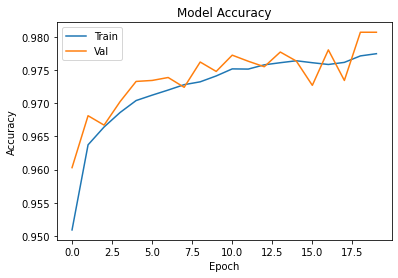

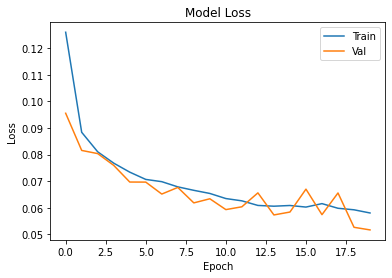

In [189]:

plot_acc(history1)

plot_loss(history1)

In [190]:
prediccionUsandoElModelo(model)
prediccionUsandoElModelo(model, 72, 320)
prediccionUsandoElModelo(model, 107, 124)
prediccionUsandoElModelo(model, 678, 560)

Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 0 - Probabilidad de ser anomalía 1 -> Etiqueta real Anomalia
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal
Probabilidad de no ser anomalía 1 - Probabilidad de ser anomalía 0 -> Etiqueta real Normal


## Probamos nuevamente nuestra regresion logistica con nuestros datos de laboratorio

Predicción [1], valor real 1
score de entrenamiento: 0.8559762873388796
score de pruebas: 0.8552576307385532


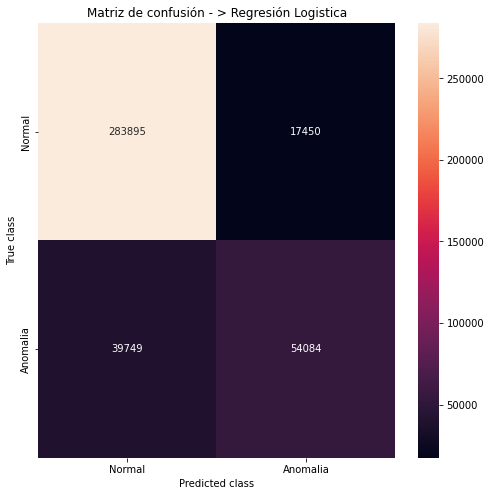

              precision    recall  f1-score   support

           0       0.88      0.94      0.91    301345
           1       0.76      0.58      0.65     93833

    accuracy                           0.86    395178
   macro avg       0.82      0.76      0.78    395178
weighted avg       0.85      0.86      0.85    395178



In [192]:
logisticRegr.fit(train_, train_lbl)

valorAComparar = 8
print("Predicción {0}, valor real {1}".format(
                    logisticRegr.predict(test_[valorAComparar].reshape(1,-1)),test_lbl[valorAComparar]))

print("score de entrenamiento: {0}".format(logisticRegr.score(train_, train_lbl)))
print("score de pruebas: {0}".format(logisticRegr.score(test_, test_lbl)))

y_pred = logisticRegr.predict(test_)

mostrar_resultados(test_lbl, y_pred, "Matriz de confusión - > Regresión Logistica")

### Resumen: 
#####    Hemos logrado entrenar nuestro modelo con los datos de estudio, usando diferentes algoritmos de clasificación obteniendo excelentes resultados, en algunos casos reduciendo nuestro dataset a nivel de columna, eliminando columnas que no aportan a nuestro modelo lo suficiente, como es el caso de attack, level, durations, entre otras que no contenían mas de una características, permitiendo aun, obtener buenos resultados a nivel porcentual, en mucho de los caso mayor al 80% de precisión a la hora de clasificar tipos de ataques.